In [ ]:
!pip install keras

In [ ]:
!pip show tensorflow

In [ ]:
!pip install pandas openpyxl

In [ ]:
!pip install transformers


### IMPORT

In [41]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from tensorflow.python.keras import metrics
from tensorflow.keras import metrics

### DATA PREPROCESSING

#### IMPORT & INFO 
 ORIGIN DATA - DATA WITH CAHTGPT LABALING

In [42]:
# Load the CSV file
data = pd.read_csv('GPTClassification.csv')
data.name = 'origin_df'
data.shape

(364, 2)

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  364 non-null    object
 1   category  362 non-null    object
dtypes: object(2)
memory usage: 5.8+ KB


In [44]:
data.head(10)

,Sentence,category
0,"""I think there should be many various sitting ...",Land use
1,"""It should be distinctive but still matching t...",Local identity
2,"""It should be clear where the entrance is and ...",Land use
3,"""well I think that the spaces should be focuse...","Land use, Future of work"
4,"""well it could be achieved through different m...",Land use
5,"""yes, the current building, as unsuitable as i...",Local identity
6,"""maybe, however Im interested in your suggesti...",other
7,"""i find that a very correct approach... how di...",other
8,"""correct again """,other
9,"""well maybe it is a possibility to experiment ...",Local identity


#### CLEAN DATA

In [45]:
empty_string_count = (data['category'] == 'other').sum()
print("There is ", empty_string_count, " sentence that are not labeled")

There is  93  sentence that are not labeled


In [46]:
# delete the NuN values
data = data.dropna()

In [47]:
total_duplicate_titles = sum(data["Sentence"].duplicated())
print(f"There are {total_duplicate_titles} duplicate Sentences.")

There are 14 duplicate Sentences.


In [48]:
# Create a boolean mask for duplicated sentences
mask = data["Sentence"].duplicated(keep=False)
print("DUPLICATE ROWS")
# Print the rows with duplicated sentences
data[mask]


DUPLICATE ROWS


,Sentence,category
17,"""no""",other
51,"""What spaces should be in the building?""","Future of work, Land use"
54,"""What should the building look like? """,Local identity
71,"""What spaces should be in the building?""",Land use
74,"""What should the building look like? """,Local identity
85,"""Hi Zaha""",other
97,"""What would you like to know""",other
123,"""spaces""","Environment and climate resilience, Land use"
127,"""trees grass""","Environment and climate resilience, Land use"
129,"""spaces""","Environment and climate resilience, Land use"


In [49]:
data = data[~data["Sentence"].duplicated()]
print(f"duplicate rows:  {len(data)}")

# There are some categories with occurrence as low as 1.
print("categories upon once only:",sum(data["category"].value_counts() == 1))

# How many unique terms?
print("unique categories:",data["category"].nunique())

duplicate rows:  348
categories upon once only: 14
unique categories: 31


We need to handle the categories upon only once, its problematic for multi-label text classifier

In [50]:
def get_single_occurrence_categories(data):
    # Get the categories that appear only once
    single_occurrence_categories = data['category'].value_counts()
    single_occurrence_categories = single_occurrence_categories[single_occurrence_categories == 1].index

    # Get the rows where 'category' is in the list of single-occurrence categories
    once_sen = data[data['category'].isin(single_occurrence_categories)]
    return once_sen


In [51]:
print("sentences that their label is unique in the data set:")
once_sen = get_single_occurrence_categories(data)
once_sen


sentences that their label is unique in the data set:


,Sentence,category
15,"""hi, i think if there´s more free use co-worki...","Local identity, Environment and climate resili..."
19,"""The building should be more open for the soci...","Local identity, Environment and climate resili..."
22,"""To have a cafe on the ground floor would be n...","Local identity, Mobility (transport)"
53,"""Can we have a garden?""","Land use, Environment and climate resilience"
110,"""I agree! Architecture students should be insp...","Environment and climate resilience, Future of ..."
145,"""The building should have several spaces for g...","Environment and climate resilience, Local iden..."
183,"""Can I 3d print infra lightweight concrete?""",Future of work; Land use
194,"""I think it should be more inviting compared t...",Local identity; Land use
198,"""There should be greenery aroud the building, ...",Environment and climate resilience; Land use
226,"""I think that a good architecture school shoul...",Land use; Local identity


In [52]:
# Replace ";" with ","
data['category'] = data['category'].str.replace(';', ',')


In [53]:
data["category"] = data["category"].apply(
    lambda x: x.split(', ')
)
data["category"].values[:5]


array([list(['Land use']), list(['Local identity']), list(['Land use']),
       list(['Land use', 'Future of work']), list(['Land use'])],
      dtype=object)

In [54]:
print("after replace ';', \nsentences that their label is unique in the data set: ")
once_sen = get_single_occurrence_categories(data)
once_sen

after replace ';', 
sentences that their label is unique in the data set: 


,Sentence,category
15,"""hi, i think if there´s more free use co-worki...","[Local identity, Environment and climate resil..."
19,"""The building should be more open for the soci...","[Local identity, Environment and climate resil..."
22,"""To have a cafe on the ground floor would be n...","[Local identity, Mobility (transport)]"
53,"""Can we have a garden?""","[Land use, Environment and climate resilience]"
110,"""I agree! Architecture students should be insp...","[Environment and climate resilience, Future of..."
145,"""The building should have several spaces for g...","[Environment and climate resilience, Local ide..."
239,"""Hello Zaha, nice to meet you! I'm glad to be ...","[Environment and climate resilience, Local ide..."
316,"""I hope in office room or big classroom there ...",[Indoor comfort]
335,"""Who's your favorite architect what's your fav...","[Mobility (transport), Local identity]"


The categories that appear once in the data we took from 14 to 9.
Now for those 9 - we will separate them to different rows

In [55]:
# Create a list to store the new rows
new_rows = []

# Iterate over the rows in the dataframe where category is in single_occurrence_categories
for idx, row in once_sen.iterrows():
    # Iterate over the categories in the 'category' column
    for cat in row['category']:
        new_row = {'Sentence': row['Sentence'], 'category': [cat]}
        # Only add the new row if it is not already in new_rows
        if new_row not in new_rows:
            new_rows.append(new_row)
    data = data.drop(idx)

# Create a new DataFrame from the new rows
new_rows_df = pd.DataFrame(new_rows)

# Append the new rows to the dataframe using concat
data = pd.concat([data, new_rows_df], ignore_index=True)


In [56]:
# Convert lists in 'category' to tuples
new_rows_df['category'] = new_rows_df['category'].apply(tuple)

# Then check for duplicates
total_duplicate_titles = new_rows_df.duplicated().sum()
print(f"There are {total_duplicate_titles} duplicates.")



There are 0 duplicates.


In [57]:
# There are some categories with occurrence as low as 1.
print(once_sen['Sentence'][19])
data[data['Sentence'] == once_sen['Sentence'][19]]
# this cell for checking it was separated

"The building should be more open for the society."


,Sentence,category
342,"""The building should be more open for the soci...",[Local identity]
343,"""The building should be more open for the soci...",[Environment and climate resilience]


In [58]:
data.shape

(361, 2)

In [59]:
# Get the categories that appear more than once
multi_occurrence_categories = data['category'].value_counts()
multi_occurrence_categories = multi_occurrence_categories[multi_occurrence_categories > 1].index

# Filter the data to only include rows where 'category' is in the list of multi-occurrence categories
data = data[data['category'].isin(multi_occurrence_categories)]


In [60]:
data.shape

(360, 2)

#### SPLIT DATA - train, validation, test

In [61]:
test_split = 0.2


# Initial train and test split.
train_df, test_df = train_test_split(
    data,
    test_size=test_split,
    stratify=data["category"].values,
    random_state=42
)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")



Number of rows in training set: 288
Number of rows in validation set: 36
Number of rows in test set: 36


#### MULTI HOT ENCODING
We will convert the  categorical data into a form that can be used by deep learning models.
because we are dealing with multi-label classification problem.


In [62]:
# Convert tensors to numpy arrays and then to sets of tuples for set operations
train_categories_tensor = tf.ragged.constant(train_df["category"].values)
test_categories_tensor = tf.ragged.constant(test_df["category"].values)

train_categories = set(tuple(x) for x in train_categories_tensor.to_list())
test_categories = set(tuple(x) for x in test_categories_tensor.to_list())

categories_not_in_train = test_categories - train_categories

print(categories_not_in_train)


set()


the result is an empty set (set())- it means there are no categories that exist in the test set but not in the training set

In [63]:
categories = tf.ragged.constant(train_df["category"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot", num_oov_indices=0)
lookup.adapt(categories)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)

Vocabulary:

['Land use', 'other', 'Environment and climate resilience', 'Local identity', 'Future of work', 'Mobility (transport)']


In [64]:
sample_label = train_df["category"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['other']
Label-binarized representation: [[0. 1. 0. 0. 0. 0.]]


In [65]:
train_df["Sentence"].apply(lambda x: len(x.split(" "))).describe()


count    288.000000
mean      13.385417
std       22.621890
min        1.000000
25%        5.000000
50%        8.000000
75%       14.000000
max      179.000000
Name: Sentence, dtype: float64

 the 75th percentile is at 13, meaning that 75% of the sentences have a length of 13 or less.
 and the maximum length observed is 179

#### MAKE DATASET OBJECT FROM DF

In [66]:

max_seqlen = 20
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["category"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["Sentence"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [67]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)


#### DATA DISTRIBUTION 

In [68]:
from collections import Counter

def label_distribution(df):
    flat_categories = [category for sublist in df["category"] for category in sublist]
    counts = Counter(flat_categories)
    print("distribution:")
    for category, count in counts.items():
        print(f"{category}: {count}")
    print("")

In [69]:
print("DATA")
label_distribution(data)
pd.DataFrame(data["Sentence"].apply(lambda x: len(x.split(" "))).describe())

DATA
distribution:
Land use: 108
Local identity: 73
Future of work: 48
other: 88
Environment and climate resilience: 76
Mobility (transport): 12



,Sentence
count,360.000000
mean,13.208333
std,22.649772
min,1.000000
25%,5.000000
50%,8.000000
75%,13.000000
max,179.000000


In [70]:
print("TRAIN")
label_distribution(train_df)
pd.DataFrame(train_df["Sentence"].apply(lambda x: len(x.split(" "))).describe())

TRAIN
distribution:
other: 70
Mobility (transport): 10
Land use: 86
Environment and climate resilience: 61
Local identity: 59
Future of work: 39



,Sentence
count,288.000000
mean,13.385417
std,22.621890
min,1.000000
25%,5.000000
50%,8.000000
75%,14.000000
max,179.000000


In [71]:
print("\nVAL")
label_distribution(val_df)
pd.DataFrame(val_df["Sentence"].apply(lambda x: len(x.split(" "))).describe())


VAL
distribution:
Future of work: 6
other: 11
Land use: 9
Local identity: 7
Environment and climate resilience: 5



,Sentence
count,36.000000
mean,13.305556
std,29.234832
min,1.000000
25%,4.750000
50%,8.000000
75%,12.000000
max,179.000000


In [72]:
print("\nTEST")
label_distribution(test_df)
pd.DataFrame(test_df["Sentence"].apply(lambda x: len(x.split(" "))).describe())


TEST
distribution:
other: 7
Local identity: 7
Mobility (transport): 2
Environment and climate resilience: 10
Land use: 13
Future of work: 3



,Sentence
count,36.000000
mean,11.694444
std,14.435709
min,1.000000
25%,5.000000
50%,8.000000
75%,13.250000
max,87.000000


In [73]:
print("EXAMPLE OF HOT-ENCODING")
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[1:2]):
    label = label_batch[i].numpy()[None, ...]
    print(label[0])
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")


EXAMPLE OF HOT-ENCODING
[1. 0. 0. 0. 0. 0.]
Abstract: b'"How about we meet later for a beer"'
Label(s): ['Land use']
 


In [74]:
vocabulary = set()
train_df["Sentence"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print("vocabulary_size: ",vocabulary_size)

vocabulary_size:  1090


### BERT MODEL

In [75]:
# Load the LaBSE model and preprocessor from tfhub.dev
encoder = hub.KerasLayer("https://tfhub.dev/jeongukjae/smaller_LaBSE_15lang/1")
preprocessor = hub.KerasLayer("https://tfhub.dev/jeongukjae/smaller_LaBSE_15lang_preprocess/1")


In [76]:
def get_labse_embeddings(text, label):
    # Preprocess the text
    encoder_inputs = preprocessor(text)
    # Get the LaBSE embeddings
    sentence_representation = encoder(encoder_inputs)["pooled_output"]
    # Normalize the embeddings
    normalized_sentence_representation = tf.nn.l2_normalize(sentence_representation, axis=-1)
    return (normalized_sentence_representation, label)

# Apply the function to your datasets
train_dataset = train_dataset.map(get_labse_embeddings, num_parallel_calls=auto).prefetch(auto)
validation_dataset = validation_dataset.map(get_labse_embeddings, num_parallel_calls=auto).prefetch(auto)
test_dataset = test_dataset.map(get_labse_embeddings, num_parallel_calls=auto).prefetch(auto)


### Create a text classification Model

In [77]:
from tensorflow.keras import layers
def make_model():
    mlp_model = tf.keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(128, activation="relu"),
            layers.Dense(64, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return mlp_model


## Train the model

#### class to evaluate the model

In [78]:
class F1Score(metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = metrics.Precision()
        self.recall = metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

    def result(self):
       precision = self.precision.result()
       recall = self.recall.result()
       return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

In [79]:
epochs = 16

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=[
        "binary_accuracy", #"binary_accuracy" checks for each position if the prediction is correct.
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall'),
        F1Score()
    ]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)

Epoch 1/16
3/3 [==============================] - 93s 9s/step - loss: 0.6842 - binary_accuracy: 0.6545 - precision: 0.1583 - recall: 0.1938 - f1_score: 0.1743 - val_loss: 0.6434 - val_binary_accuracy: 0.8241 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/16
3/3 [==============================] - 89s 9s/step - loss: 0.6238 - binary_accuracy: 0.8119 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.5392 - val_binary_accuracy: 0.8241 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 3/16
3/3 [==============================] - 96s 9s/step - loss: 0.5148 - binary_accuracy: 0.8119 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.4374 - val_binary_accuracy: 0.82

In [80]:
# Save the model
shallow_mlp_model.save('model_text_clf_bert_80_FINAL.h5')

In [82]:
def plot_evaluate(model):
    def plot_result(item):
        plt.plot(model.history.history[item], label=item)
        plt.plot(model.history.history["val_" + item], label="val_" + item)
        plt.xlabel("Epochs")
        plt.ylabel(item)
        plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
        plt.legend()
        plt.grid()
        plt.show()

        last_train_result = model.history.history[item][-1]
        last_val_result = model.history.history["val_" + item][-1]
        print("Last {} (train): {:.4f}".format(item, last_train_result))
        print("Last {} (validation): {:.4f}".format(item, last_val_result))

    plot_result("loss")
    plot_result("binary_accuracy")
    plot_result("precision")
    plot_result("recall")
    plot_result("f1_score")

In [ ]:
test_df.to_csv("test_df_80.csv", index=False)

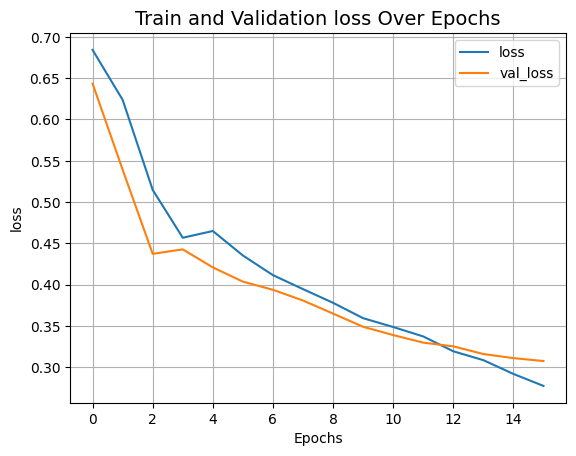

Last loss (train): 0.2775
Last loss (validation): 0.3076


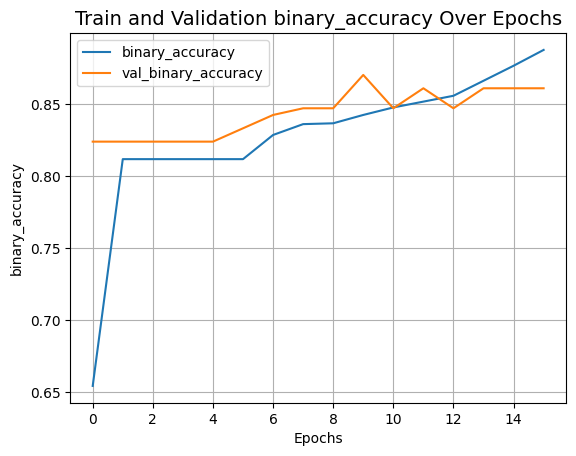

Last binary_accuracy (train): 0.8877
Last binary_accuracy (validation): 0.8611


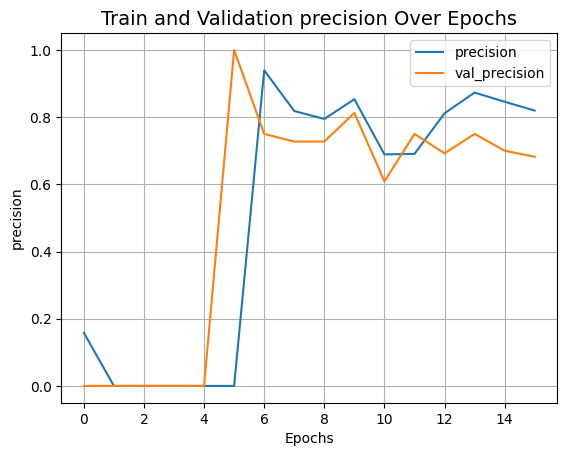

Last precision (train): 0.8195
Last precision (validation): 0.6818


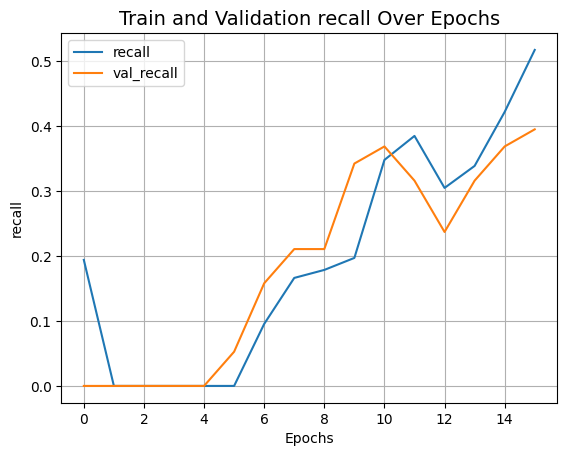

Last recall (train): 0.5169
Last recall (validation): 0.3947


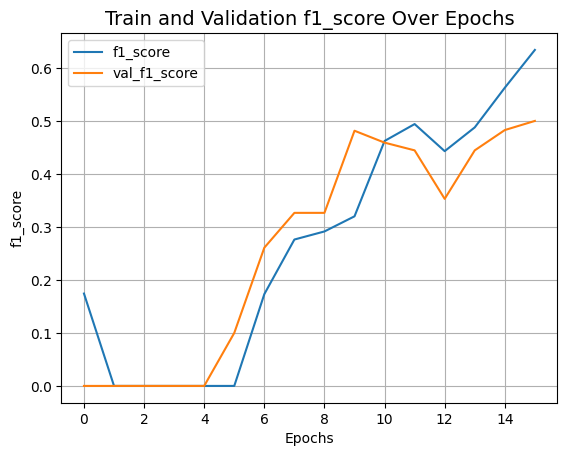

Last f1_score (train): 0.6340
Last f1_score (validation): 0.5000


In [83]:
plot_evaluate(shallow_mlp_model)


### Test part:
1. Predict labels for the test set using the model.
2. Convert these predicted probabilities to binary format (0 or 1) using a threshold of 0.5.
3. For each category:
* Extract the true and predicted labels for this category.
* Calculate and print the accuracy, precision, recall, and F1 score.
* Calculate and plot a confusion matrix for the category.


<MapDataset element_spec=TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)>

In [127]:
# Generate predictions on the test set
y_pred = shallow_mlp_model.predict(test_dataset)

1/1 [==============================] - 20s 20s/step


In [137]:
binary_predictions = np.round(y_pred)

In [138]:
y_true = np.vstack(test_dataset.map(lambda x, y: y).as_numpy_iterator())

C:\Users\PC\AppData\Local\Temp\ipykernel_4512\97231176.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_true = np.vstack(test_dataset.map(lambda x, y: y).as_numpy_iterator())


Category 1:

Accuracy: 0.8611111111111112
Precision: 0.9
Recall: 0.6923076923076923
F1 Score: 0.7826086956521738



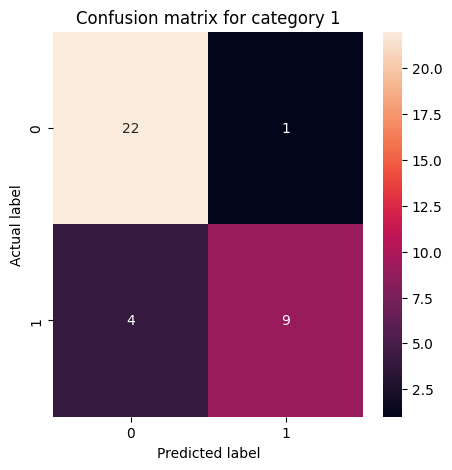

Category 2:

Accuracy: 0.8611111111111112
Precision: 0.75
Recall: 0.42857142857142855
F1 Score: 0.5454545454545454



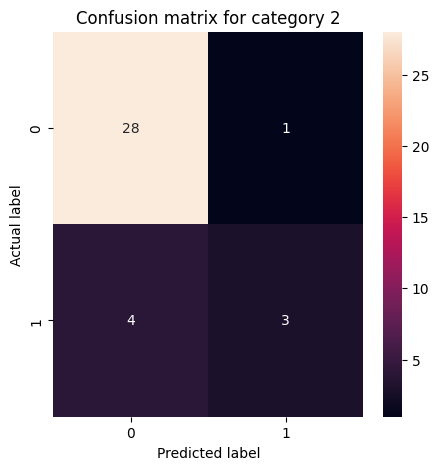

Category 3:

Accuracy: 0.8055555555555556
Precision: 0.8
Recall: 0.4
F1 Score: 0.5333333333333333



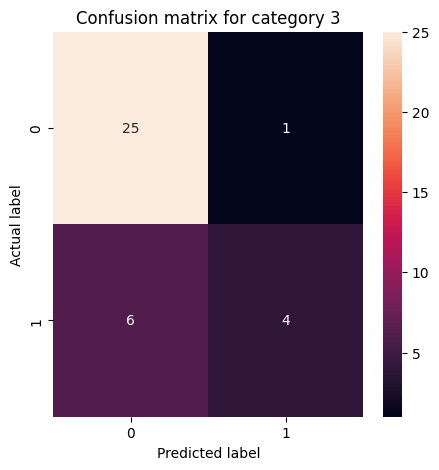

Category 4:

Accuracy: 0.8055555555555556
Precision: 0.0
Recall: 0.0
F1 Score: 0.0



c:\users\pc\pycharmprojects\colombia\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


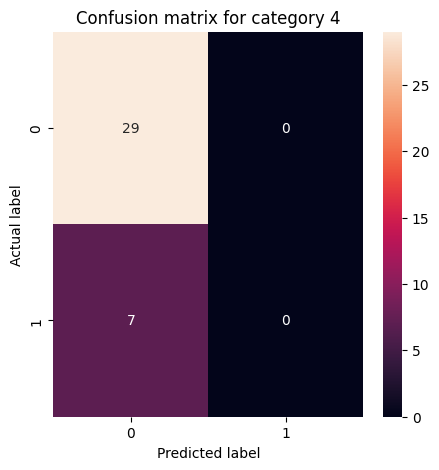

Category 5:

Accuracy: 0.9166666666666666
Precision: 0.0
Recall: 0.0
F1 Score: 0.0



c:\users\pc\pycharmprojects\colombia\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


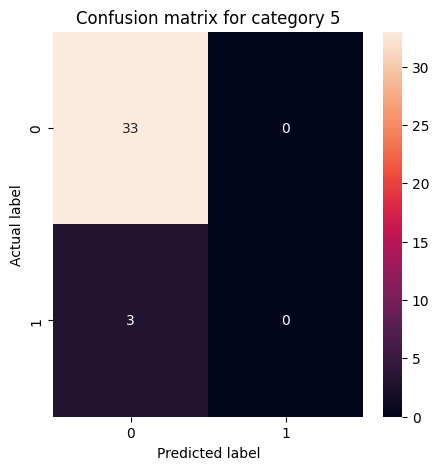

Category 6:

Accuracy: 0.9444444444444444
Precision: 0.0
Recall: 0.0
F1 Score: 0.0



c:\users\pc\pycharmprojects\colombia\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


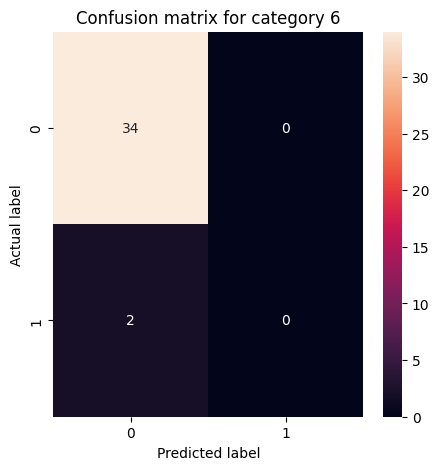

In [132]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np

for i in range(binary_predictions.shape[1]):
    print(f"Category {i+1}:\n")
    true_labels = y_true[:, i]
    predicted_labels = binary_predictions[:, i]

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}\n")

    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(f'Confusion matrix for category {i+1}')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

------------------------------------------------------------------------

### TRAIN RESULTS
#### BERT MODEL
#### 70% TRAIN, 30% TEST

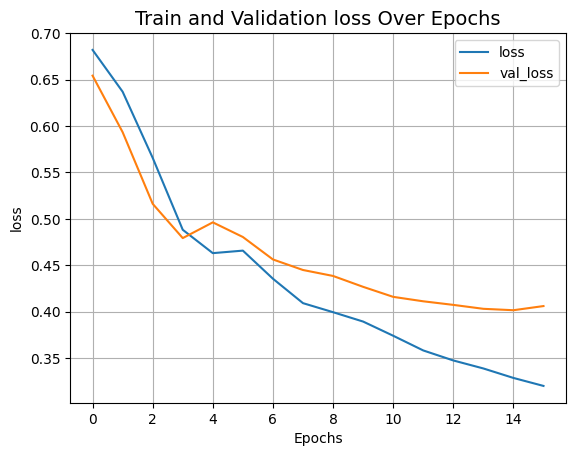

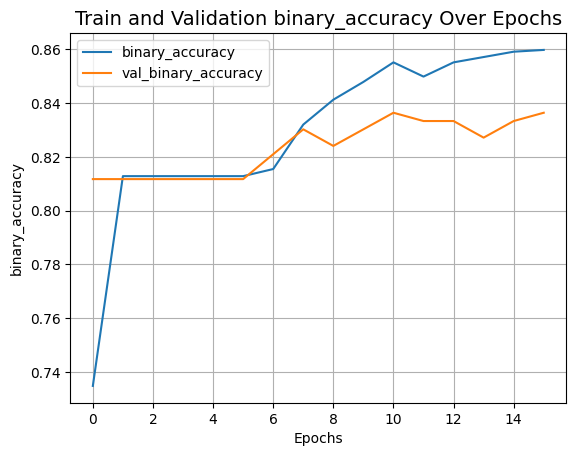

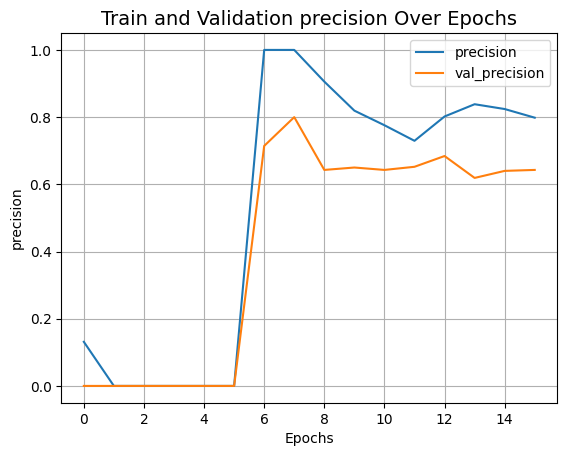

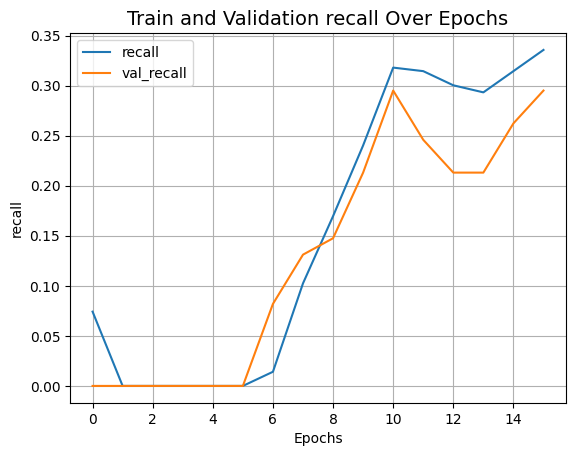

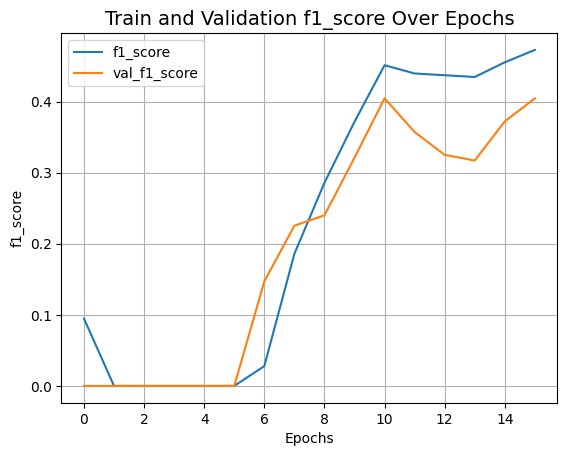

In [ ]:
plot_evaluate(shallow_mlp_model)

In [ ]:
test_df.to_csv("test_df_70.csv", index=False)

### Test part:
1. Predict labels for the test set using the model.
2. Convert these predicted probabilities to binary format (0 or 1) using a threshold of 0.5.
3. For each category:
* Extract the true and predicted labels for this category.
* Calculate and print the accuracy, precision, recall, and F1 score.
* Calculate and plot a confusion matrix for the category.

In [ ]:
# Generate predictions on the test set
y_pred = shallow_mlp_model.predict(test_dataset)

In [ ]:
# Convert predictions to binary format (0 or 1)
binary_predictions = np.round(y_pred)

In [ ]:
y_pred

In [ ]:
y_true = np.vstack(test_dataset.map(lambda x, y: y).as_numpy_iterator())

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np

for i in range(binary_predictions.shape[1]):
    print(f"Category {i+1}:\n")

    true_labels = y_true[:, i]
    predicted_labels = binary_predictions[:, i]

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}\n")

    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(f'Confusion matrix for category {i+1}')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()


#### BERT MODEL
#### 80% TRAIN, 20% TEST

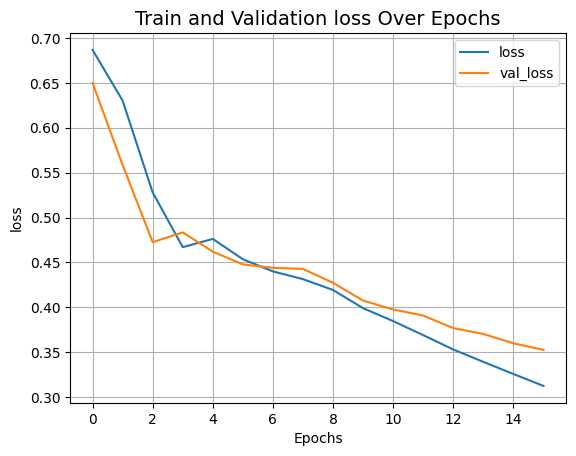

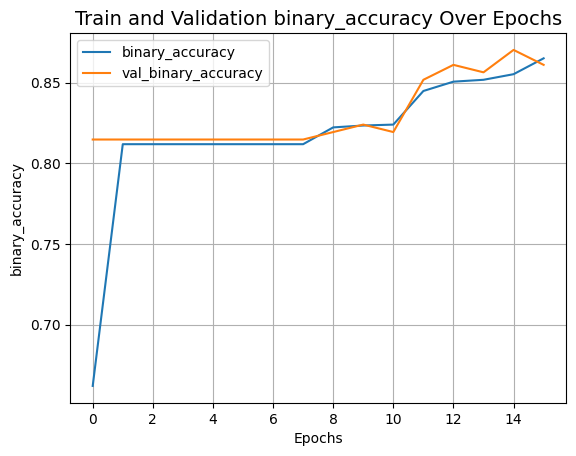

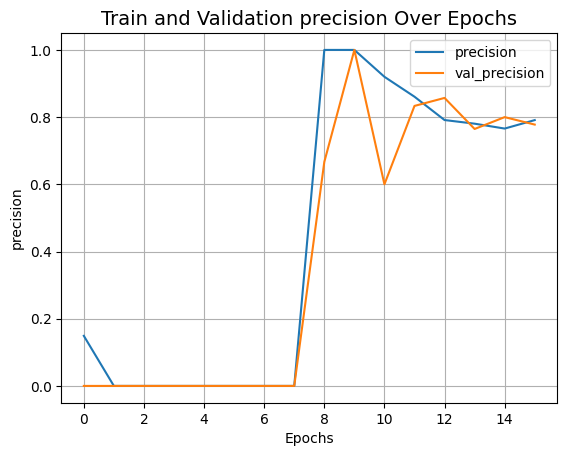

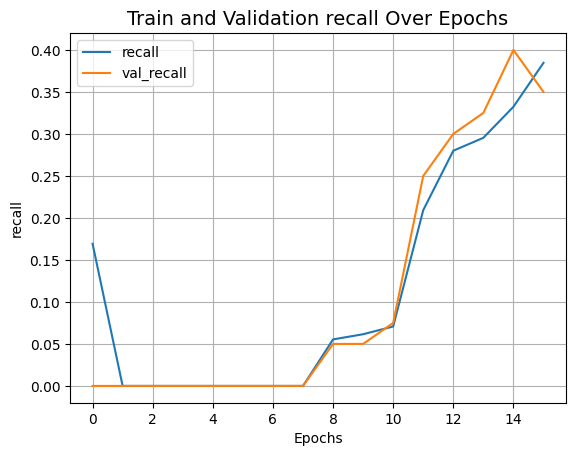

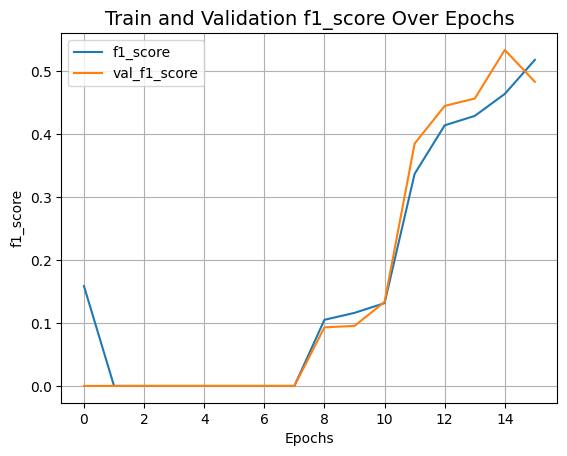

In [ ]:
plot_evaluate(shallow_mlp_model)

In [ ]:
test_df.to_csv("test_df_80.csv", index=False)

### Test part:
1. Predict labels for the test set using the model.
2. Convert these predicted probabilities to binary format (0 or 1) using a threshold of 0.5.
3. For each category:
* Extract the true and predicted labels for this category.
* Calculate and print the accuracy, precision, recall, and F1 score.
* Calculate and plot a confusion matrix for the category.

In [ ]:
# Generate predictions on the test set
y_pred = shallow_mlp_model.predict(test_dataset)

1/1 [==============================] - 15s 15s/step


In [ ]:
# Convert predictions to binary format (0 or 1)
binary_predictions = np.round(y_pred)

In [ ]:
y_pred

NameError: name 'y_pred' is not defined

C:\Users\PC\AppData\Local\Temp\ipykernel_8520\1785652194.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_true = np.vstack(test_dataset.map(lambda x, y: y).as_numpy_iterator())


Category 1:

Accuracy: 0.75
Precision: 0.8
Recall: 0.3333333333333333
F1 Score: 0.47058823529411764



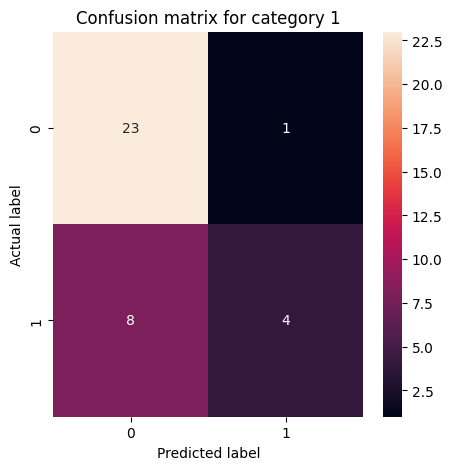

Category 2:

Accuracy: 0.9444444444444444
Precision: 0.9
Recall: 0.9
F1 Score: 0.9



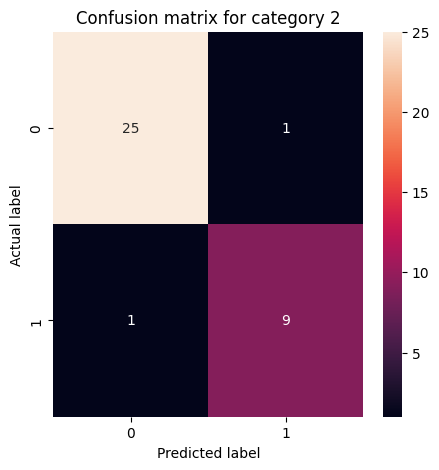

Category 3:

Accuracy: 0.7777777777777778
Precision: 0.5
Recall: 0.25
F1 Score: 0.3333333333333333



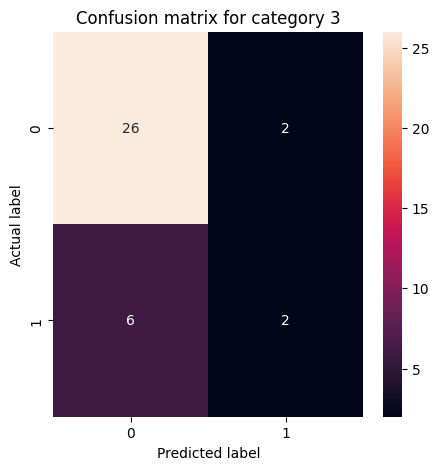

Category 4:

Accuracy: 0.8333333333333334
Precision: 0.0
Recall: 0.0
F1 Score: 0.0



c:\users\pc\pycharmprojects\colombia\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


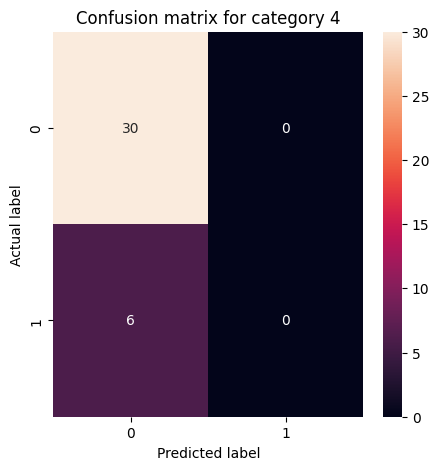

c:\users\pc\pycharmprojects\colombia\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Category 5:

Accuracy: 0.9166666666666666
Precision: 0.0
Recall: 0.0
F1 Score: 0.0



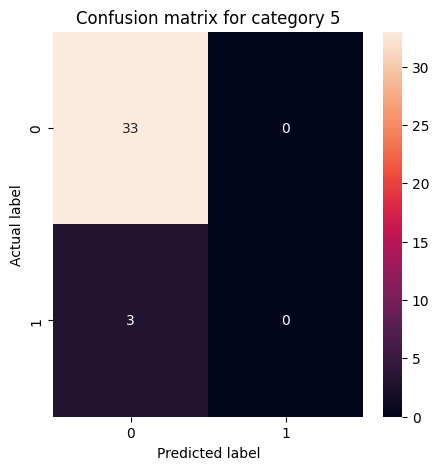

Category 6:

Accuracy: 0.9722222222222222
Precision: 0.0
Recall: 0.0
F1 Score: 0.0



c:\users\pc\pycharmprojects\colombia\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


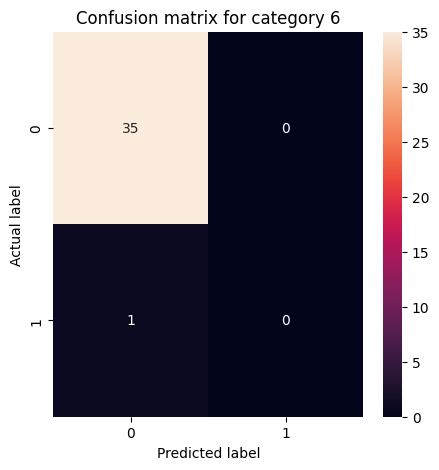

In [ ]:
y_true = np.vstack(test_dataset.map(lambda x, y: y).as_numpy_iterator())

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np

for i in range(binary_predictions.shape[1]):
    print(f"Category {i+1}:\n")

    true_labels = y_true[:, i]
    predicted_labels = binary_predictions[:, i]

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}\n")

    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(f'Confusion matrix for category {i+1}')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

For Summery:
- Category 1 (Land use): Accuracy of 85.19%
- Category 2 (Other): Accuracy of 88.89%
- Category 3 (Environment and climate resilience): Accuracy of 81.48%
- Category 4 (Local identity): Accuracy of 85.19%
- Category 5 (Future of work): Accuracy of 92.59%
- Category 6 (Mobility (transport)): Accuracy of 96.30%

### DISTRUBIOTION
 Lets check for the train and test data how many samples we have from each class:

In [139]:
from collections import Counter

# Flatten the list of categories
flat_categories = [category for sublist in train_df["category"] for category in sublist]

# Count the occurrences
counts = Counter(flat_categories)

# Print counts in a readable format
for category, count in counts.items():
    print(f" {category}: {count}")



 other: 70
 Mobility (transport): 10
 Land use: 86
 Environment and climate resilience: 61
 Local identity: 59
 Future of work: 39


In [141]:
# Flatten the list of categories
flat_categories = [category for sublist in test_df["category"] for category in sublist]

# Count the occurrences
counts = Counter(flat_categories)

# Print counts in a readable format
for category, count in counts.items():
    print(f" {category}: {count}")


 other: 7
 Local identity: 7
 Mobility (transport): 2
 Environment and climate resilience: 10
 Land use: 13
 Future of work: 3
